# Vision por Computadora II - CEIA

### Trabajo Final

Autor: Karen Raczkowski

En el siguiente trabajo se busca clasificar imágenes de diferentes razas de perros utilizando redes neuronales.

Objetivo: identificar la raza de perros en imágenes.<br>
Problema: clasificación multiclase.<br>
Cantidad de clases: 120<br>
Nombre de las clases: nombres de 120 razas de perros, por ejemplo, 'Pekinese', 'Labrador', 'Bulldog', etc.<br>
Total de imágenes del dataset: 20,580<br>
División Train-Test: 80-20%<br>
Arquitecturas de modelos: ResNet18, ResNet50, VGG19<br>

In [5]:
import random
import os
import platform
import sys
import numpy as np
import seaborn as sns
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torchvision
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as f
import torchmetrics
from tensorboardX import SummaryWriter

In [6]:
if 'google.colab' in sys.modules:
    !pip install torchmetrics
    !pip install --upgrade --no-cache-dir gdown
    import gdown

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

Descargar el dataset

In [7]:
# Correr solo si es necesario descargar el dataset
import requests

def download_file_from_onedrive(url, destination):
    response = requests.get(url, allow_redirects=True)
    if response.status_code == 200:
        with open(destination, 'wb') as file:
            file.write(response.content)
    else:
        print(f"Error al descargar el archivo: {response.status_code}")

# Enlace de descarga directa de OneDrive
onedrive_link = "https://onedrive.live.com/download.aspx?authkey=%21AERlgCBx8y6ZrOU&resid=75263E3DFDFB225E%2165439&cid=75263E3DFDFB225E&parId=root&parQt=sharedby&parCid=UnAuth&o=OneUp"

# Ruta de destino donde quieres guardar el archivo
destination_file = "Stanford_Dogs_Dataset.zip"

# Descargar el archivo
download_file_from_onedrive(onedrive_link, destination_file)

print(f"Archivo descargado en: {destination_file}")

Archivo descargado en: Stanford_Dogs_Dataset.zip


In [8]:
# Descomprimir
import zipfile

# Función para descomprimir el archivo
def unzip_file(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Descomprimir el archivo
unzip_file("Stanford_Dogs_Dataset.zip", "./Stanford_Dogs_Dataset/")

print(f"Archivo descomprimido")

Archivo descomprimido


### Exploración del conjunto de datos

Exploramos el contenido del dataset para obtener una idea más clara de las razas y las imágenes con las que vamos a trabajar.

In [9]:
import glob

# Cargar la lista de nombres de las razas de perros
breeds = [item for item in sorted(glob.glob('./Stanford_Dogs_Dataset/images/Images/*'))]

# Imprimir estadísticas sobre el conjunto de datos
print('Hay un total de %d categorías de razas de perros.' % len(breeds))

# Inicializar un contador para el número total de imágenes
total_images = 0

# Contar el número de imágenes por raza
for breed in breeds:
    # Contar el número de archivos en el directorio de cada raza
    num_images = len(glob.glob(breed + '/*'))
    total_images += num_images

print('Hay un total de %d imágenes de perros.' % total_images)

Hay un total de 120 categorías de razas de perros.
Hay un total de 20580 imágenes de perros.


Observamos la distribución del número de razas en nuestros datos proporcionados Las razas más representadas son el maltés, el lebrel afgano, el lebrel escocés, el pomerania y el lobero irlandés.

In [12]:
path = './Stanford_Dogs_Dataset/images/Images/'

# Diccionario para almacenar el conteo de imágenes por raza
conteo_imagenes = {}

# Recorrer cada carpeta en el directorio
for raza in os.listdir(path):
    # Construir la ruta completa a la carpeta de la raza
    raza_path = os.path.join(path, raza)
    
    # Asegurarse de que es un directorio
    if os.path.isdir(raza_path):
        # Dividir el nombre de la carpeta para eliminar la parte numérica
        nombre_raza = raza.split('-')[-1]

        # Contar el número de archivos en el directorio
        conteo_imagenes[nombre_raza] = len([nombre for nombre in os.listdir(raza_path) if os.path.isfile(os.path.join(raza_path, nombre))])

# Ordenar el conteo de imágenes por raza de mayor a menor
conteo_ordenado = dict(sorted(conteo_imagenes.items(), key=lambda item: item[1], reverse=True))

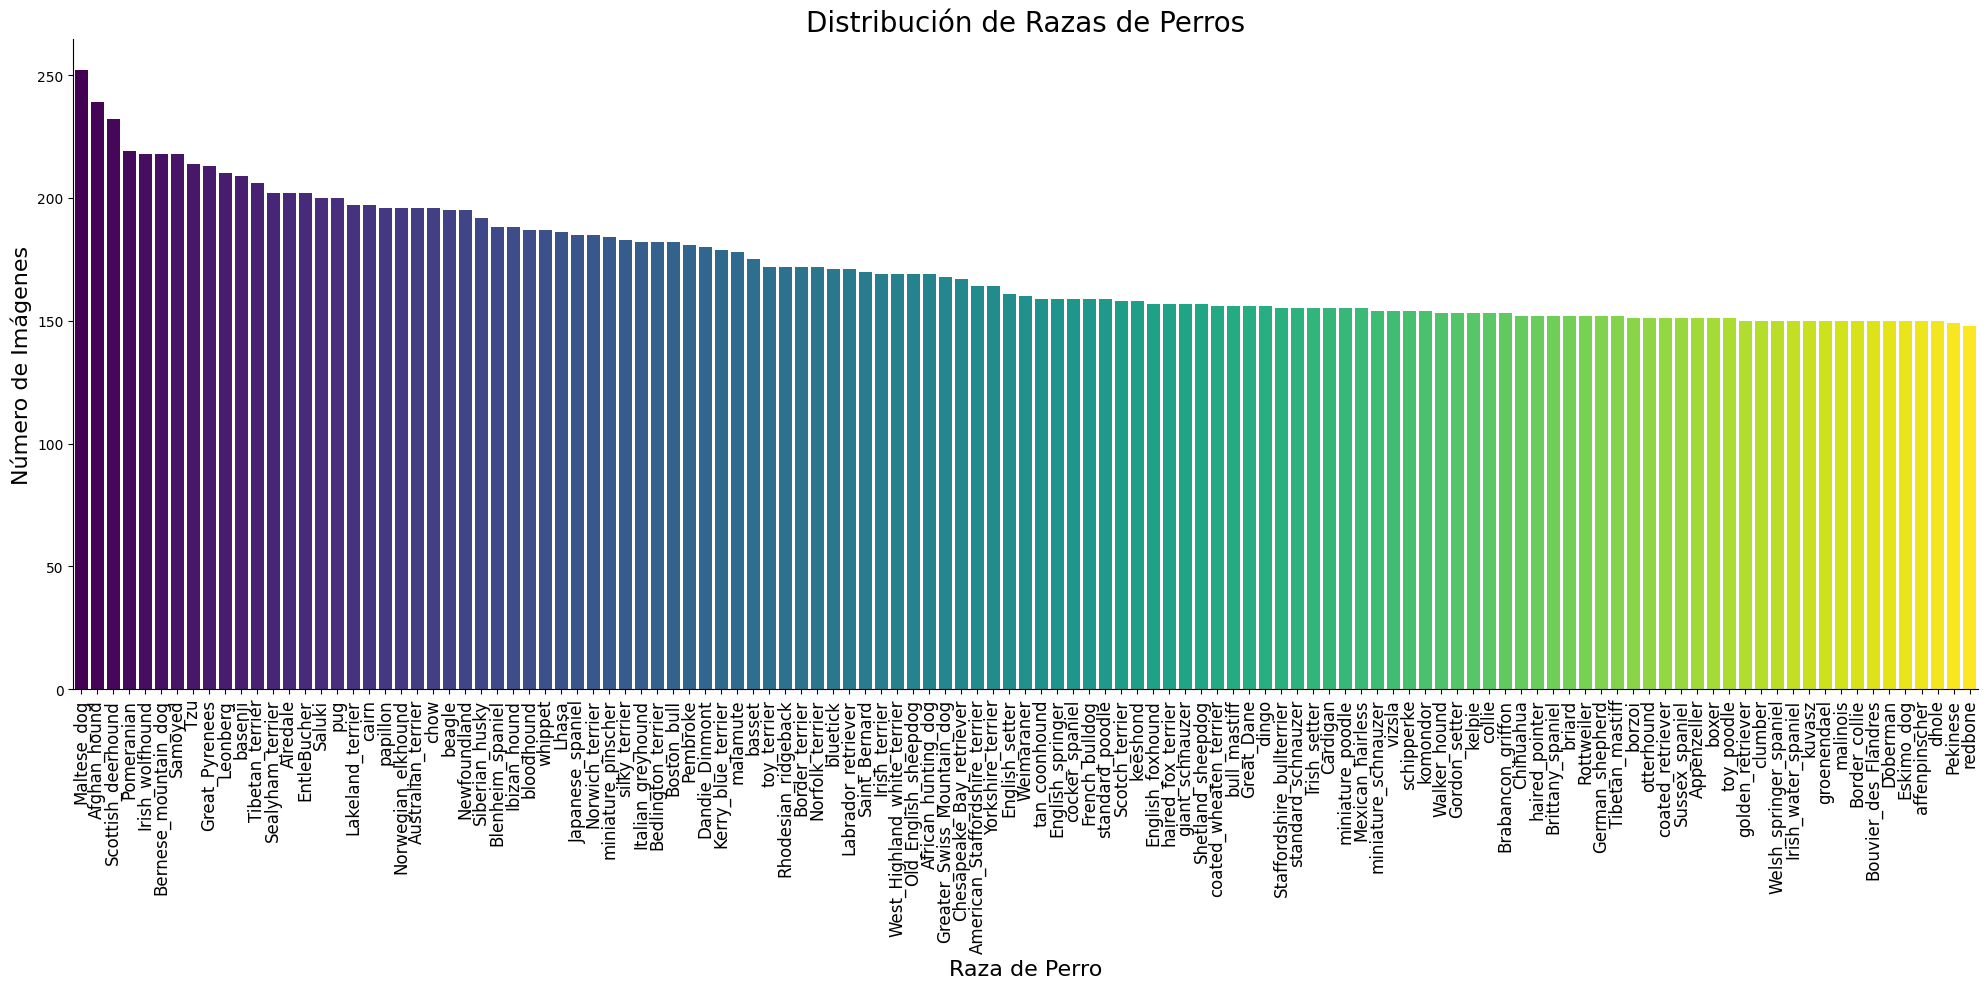

In [13]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

# Suponiendo que 'conteo_ordenado' es tu diccionario con el conteo de imágenes
razas = list(conteo_ordenado.keys())
conteos = list(conteo_ordenado.values())

# Crear gradación de colores a lo largo de las barras
colores = plt.cm.viridis(np.linspace(0, 1, len(razas)))

# Crear el gráfico de barras
plt.figure(figsize=(20, 10))  # Ajusta el tamaño según sea necesario
barras = plt.bar(razas, conteos, color=colores)

# Añadir un título y etiquetas a los ejes
plt.title('Distribución de Razas de Perros', fontsize=20)
plt.xlabel('Raza de Perro', fontsize=16)
plt.ylabel('Número de Imágenes', fontsize=16)

# Ajustar los límites del eje X para eliminar el espacio en blanco
plt.xlim(-0.5, len(razas) - 0.5)  # -0.5 establece la primera barra pegada al eje Y

# Rotar las etiquetas del eje X para mejor lectura
plt.xticks(rotation=90, fontsize=12)

# Remover las líneas de los ejes superior y derecho
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Ajustar el layout para asegurar que las etiquetas del eje X sean visibles
plt.tight_layout()

# Mostrar el gráfico
plt.show()

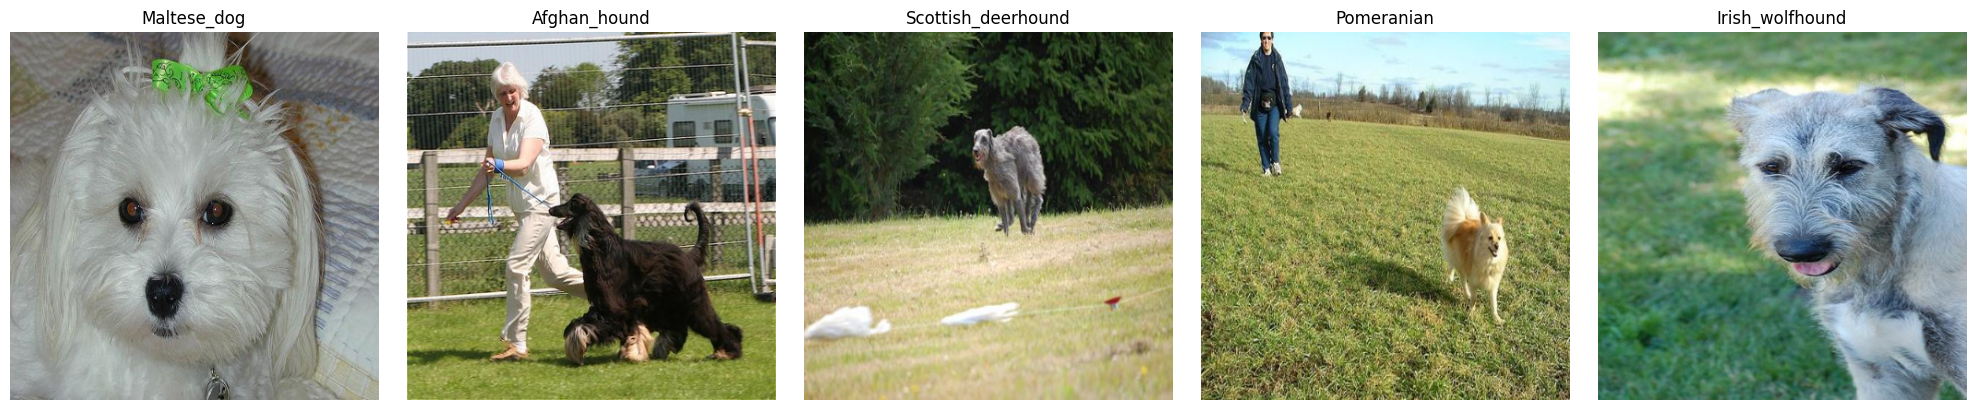

In [14]:
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from skimage.transform import resize

# Define la ruta al directorio que contiene imágenes de perros
PATH = './Stanford_Dogs_Dataset/images/Images/'

# Diccionario para almacenar el conteo de imágenes por raza
conteo_imagenes = {}

# Contar imágenes por raza
for raza in os.listdir(PATH):
    raza_path = os.path.join(PATH, raza)
    conteo_imagenes[raza] = len(os.listdir(raza_path))

# Ordenar y obtener las 5 razas con más imágenes
top_5_razas = sorted(conteo_imagenes, key=conteo_imagenes.get, reverse=True)[:5]

# Crear subplots para las 5 razas con más imágenes
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))

for i, raza in enumerate(top_5_razas):
    raza_path = os.path.join(PATH, raza)
    images = os.listdir(raza_path)
    img_path = os.path.join(raza_path, random.choice(images))

    # Cargar y mostrar la imagen usando Matplotlib
    img = plt.imread(img_path)
    img = resize(img, (400, 400), anti_aliasing=True)

    axes[i].imshow(img)
    axes[i].set_axis_off()  # Desactiva el eje para una mejor visualización

    # Extraer el nombre de la raza del nombre de la carpeta
    raza_perro = raza.split('-')[-1]  # Extrae la parte después del guion
    axes[i].set_title(raza_perro, fontsize=12)

plt.tight_layout()
plt.show()

Cantidad disponible de razas de perro: 120


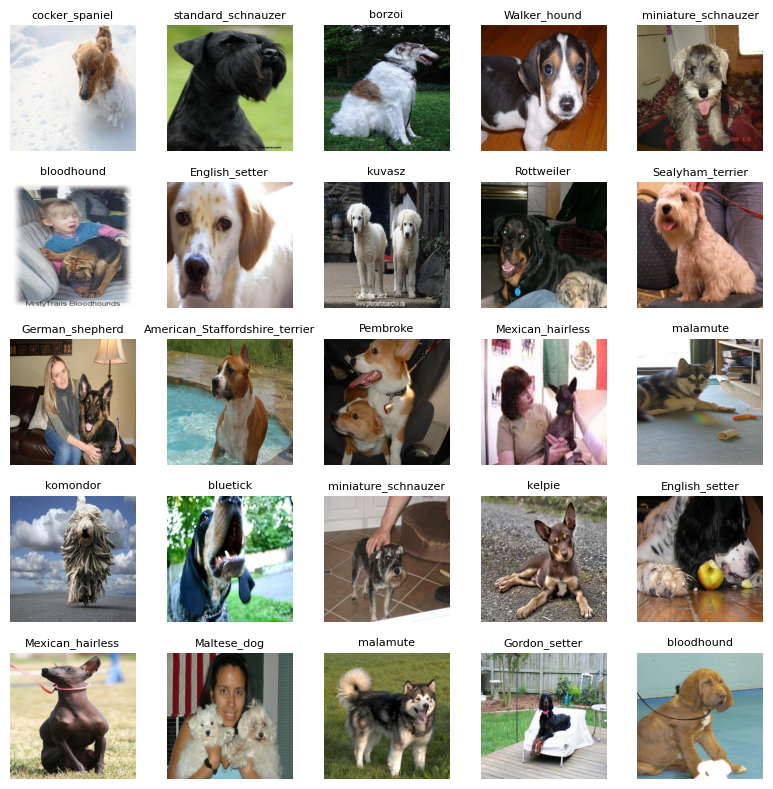

In [15]:
import random
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import numpy as np

# Define la ruta al directorio que contiene imágenes de perros
PATH = './Stanford_Dogs_Dataset/images/Images/'

# Mostrar el conteo de imágenes de perros en el directorio
print(f'Cantidad disponible de razas de perro: {len(os.listdir(PATH))}')

# Crear subplots para mostrar imágenes aleatorias
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(8,8))

# Iterar a través de los subplots y mostrar imágenes aleatorias de perros
for indx, axis in enumerate(axes.flatten()):
    PATH_TEMP = random.choice(os.listdir(PATH))
    # Obtener un índice aleatorio dentro del rango de imágenes disponibles
    rnd_indx = np.random.randint(0, len(os.listdir(PATH+'/'+PATH_TEMP)))

    # Cargar y mostrar la imagen usando Matplotlib
    images = os.listdir(PATH+'/'+PATH_TEMP+'/')
    img = plt.imread(PATH+'/'+PATH_TEMP + '/'+images[rnd_indx])
    # Redimensiona la imagen a un tamaño constante (por ejemplo, 400x400)
    img = resize(img, (400,400))

    imgplot = axis.imshow(img)
    axis.set_axis_off()  # Desactiva el eje para una mejor visualización

    # Extraer el nombre de la raza del nombre de la carpeta
    raza_perro = PATH_TEMP.split('-')[-1]  # Extrae la parte después del guion
    axis.set_title(raza_perro, fontsize=8)

plt.tight_layout()
plt.show()

### Preprocesamiento de imágenes

Aplicamos transformaciones a nuestras imágenes, redimensionándolas a 64x64 píxeles y aplicando cambios aleatorios en el color, rotación y volteo horizontal. Convertimos estas imágenes transformadas en tensores y las normalizamos. Cargamos estas imágenes en lotes de 32 desde un directorio y las mezclamos para añadir aleatoriedad. Este enfoque mejora la diversidad y el tamaño de nuestro conjunto de datos, aumentando la robustez de nuestro modelo.

Total number of samples in the dataset: 20580
Number of samples for training (80% of total): 16464
Number of samples for testing (20% of total): 4116


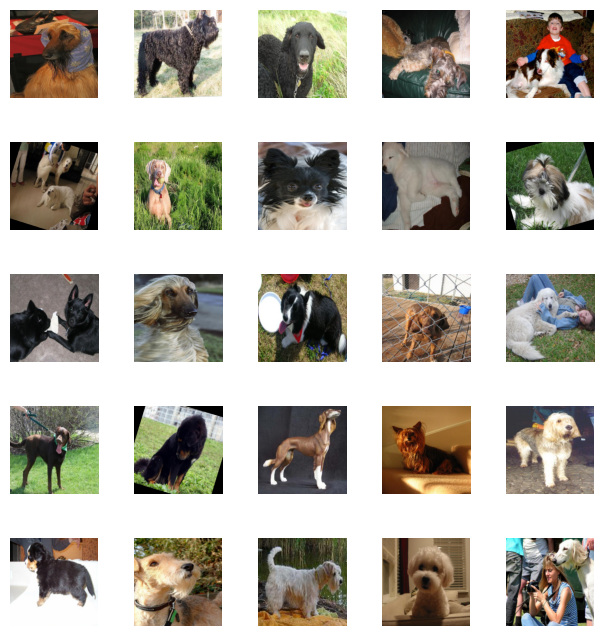

In [16]:
from torchvision import transforms, datasets
import torch
import numpy as np
import matplotlib.pyplot as plt

batch_size = 32
image_size = 64

# Define your transformations
random_transforms = [transforms.ColorJitter(), transforms.RandomRotation(degrees=20)]
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(random_transforms, p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = datasets.ImageFolder(PATH, transform=transform)

# Calculate the number of samples for training and testing
total_samples = len(dataset)
train_samples = int(0.8 * total_samples)
test_samples = total_samples - train_samples

# Print the values with descriptions
print(f"Total number of samples in the dataset: {total_samples}")
print(f"Number of samples for training (80% of total): {train_samples}")
print(f"Number of samples for testing (20% of total): {test_samples}")

# Split the dataset into training and testing sets
train_data, test_data = torch.utils.data.random_split(dataset, [train_samples, test_samples])

# Create data loaders for training and testing
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Get a batch of images
imgs, labels = next(iter(train_loader))

# Convert the tensor to a numpy array and transpose the axes
imgs = imgs.numpy().transpose(0, 2, 3, 1)

# Denormalize the images
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.5, 0.5, 0.5])
imgs = std * imgs + mean
imgs = np.clip(imgs, 0, 1)  # Ensure the values are clipped to the range [0, 1]

# Create a figure with subplots
fig, axs = plt.subplots(5, 5, figsize=(8, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

# Display the images
for i in range(25):
    axs[i].imshow(imgs[i])
    axs[i].axis('off')

plt.show()

Resnet50

In [17]:
import tensorflow as tf

batch_size = 32
random_seed = 42

train_dataset = tf.keras.utils.image_dataset_from_directory(
    PATH,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=batch_size)


Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [19]:
random_seed = 42

val_dataset = tf.keras.utils.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(224, 224),
  batch_size=batch_size,
  label_mode ="categorical")

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [20]:
class_names = train_dataset.class_names

names=[]
for name in class_names :
    names.append(name.split("-")[1])

cantidad_clases = len(class_names)

print(f'Primeras 10 clases: {names[:10]}')
print(f'Cantidad de clases: {cantidad_clases}')

Primeras 10 clases: ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound']
Cantidad de clases: 120


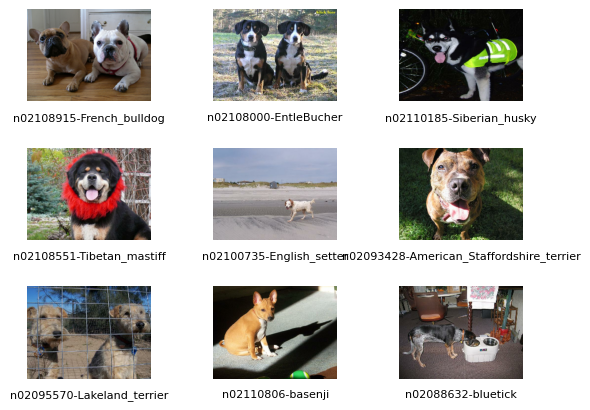

In [21]:
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)

        # Aumentar el tamaño de la imagen y agregar espacio alrededor
        plt.imshow(images[i].numpy().astype("uint8"), aspect='auto', extent=(0, 1, 0, 1))

        # Aumentar el espacio entre las imágenes
        plt.subplots_adjust(wspace=0.5, hspace=0.5)

        plt.axis("off")

        # Obtener la clase (raza de perro) correspondiente
        class_index = labels[i].numpy()
        class_name = class_names[class_index]

        plt.text(0.5, -0.2, class_name, transform=ax.transAxes, fontsize=8, ha='center')

plt.show()

In [22]:
def train(model, optimizer, criterion, metric, data, epochs, tb_writer=None):
    from PIL import ImageFile
    ImageFile.LOAD_TRUNCATED_IMAGES = True

    train_loader = data["train"]
    valid_loader = data["valid"]

    train_writer = tb_writer["train"]
    valid_writer = tb_writer["valid"]

    if tb_writer:
        train_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))
        valid_writer.add_graph(model, torch.zeros((1, 3, data["image_width"], data["image_height"])))

    if torch.cuda.is_available():
        model.to("cuda")
        metric.to("cuda")

    train_loss = []
    train_acc = []
    valid_loss = []
    valid_acc = []

    for epoch in range(epochs):

        # Pongo el modelo en modo entrenamiento
        model.train()

        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0

        for train_data, train_target in train_loader:

            if torch.cuda.is_available():
                train_data = train_data.to("cuda")
                train_target = train_target.to("cuda")

            optimizer.zero_grad()
            output = model(train_data.float())
            loss = criterion(output, train_target)
            epoch_train_loss += loss.item()
            loss.backward()
            optimizer.step()

            accuracy = metric(output, train_target)
            epoch_train_accuracy += accuracy.item()

        epoch_train_loss = epoch_train_loss / len(train_loader)
        epoch_train_accuracy = epoch_train_accuracy / len(train_loader)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_accuracy)

        # Pongo el modelo en modo testeo
        model.eval()

        epoch_valid_loss = 0.0
        epoch_valid_accuracy = 0.0

        for valid_data, valid_target in valid_loader:
            if torch.cuda.is_available():
                valid_data = valid_data.to("cuda")
                valid_target = valid_target.to("cuda")

            output = model(valid_data.float())
            epoch_valid_loss += criterion(output, valid_target).item()
            epoch_valid_accuracy += metric(output, valid_target).item()

        epoch_valid_loss = epoch_valid_loss / len(valid_loader)
        epoch_valid_accuracy = epoch_valid_accuracy / len(valid_loader)
        valid_loss.append(epoch_valid_loss)
        valid_acc.append(epoch_valid_accuracy)

        print("Epoch: {}/{} - Train loss {:.6f} - Train Accuracy {:.6f} - Valid Loss {:.6f} - Valid Accuracy {:.6f}".format(
        epoch+1, epochs, epoch_train_loss, epoch_train_accuracy, epoch_valid_loss, epoch_valid_accuracy))

        if tb_writer:
            train_writer.add_scalar("loss", epoch_train_loss, epoch)
            valid_writer.add_scalar("loss", epoch_valid_loss, epoch)
            train_writer.add_scalar("accuracy", epoch_train_accuracy, epoch)
            valid_writer.add_scalar("accuracy", epoch_valid_accuracy, epoch)
            train_writer.flush()
            valid_writer.flush()

    history = {}
    history["train_loss"] = train_loss
    history["train_acc"] = train_acc
    history["valid_loss"] = valid_loss
    history["valid_acc"] = valid_acc

    return history

In [26]:
import os

# Get the list of class names (subdirectories in your dataset directory)
class_names = sorted(os.listdir(PATH))

# Create an index-to-class mapping
idx_to_name = {cls: class_name for cls, class_name in enumerate(class_names)}

# Print the index-to-class mapping
print("Index-to-Class Mapping:")
for idx, class_name in idx_to_name.items():
    print(f"Index {idx}: Class Name {class_name}")

Index-to-Class Mapping:
Index 0: Class Name n02085620-Chihuahua
Index 1: Class Name n02085782-Japanese_spaniel
Index 2: Class Name n02085936-Maltese_dog
Index 3: Class Name n02086079-Pekinese
Index 4: Class Name n02086240-Shih-Tzu
Index 5: Class Name n02086646-Blenheim_spaniel
Index 6: Class Name n02086910-papillon
Index 7: Class Name n02087046-toy_terrier
Index 8: Class Name n02087394-Rhodesian_ridgeback
Index 9: Class Name n02088094-Afghan_hound
Index 10: Class Name n02088238-basset
Index 11: Class Name n02088364-beagle
Index 12: Class Name n02088466-bloodhound
Index 13: Class Name n02088632-bluetick
Index 14: Class Name n02089078-black-and-tan_coonhound
Index 15: Class Name n02089867-Walker_hound
Index 16: Class Name n02089973-English_foxhound
Index 17: Class Name n02090379-redbone
Index 18: Class Name n02090622-borzoi
Index 19: Class Name n02090721-Irish_wolfhound
Index 20: Class Name n02091032-Italian_greyhound
Index 21: Class Name n02091134-whippet
Index 22: Class Name n02091244-

In [27]:
def image_loader(loader, image_name):
    image = Image.open(image_name)
    image = loader(image).float().to(device)
    image.clone().detach().requires_grad_(True)
    image = image.unsqueeze(0)
    return image

In [28]:
from torchvision.models import resnet18, ResNet18_Weights
torch.cuda.empty_cache()
weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()

In [32]:
import torchsummary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet18_model = resnet18(weights=weights)
#resnet18_model = resnet18()

resnet18_model.to(device)

for param in resnet18_model.parameters():
    param.requires_grad = False

last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features,
                                    out_features=cantidad_clases)

torchsummary.summary(resnet18_model, input_size=(3, 224, 224))
resnet18_model.modules

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

<bound method Module.modules of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [33]:
optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.00001)
loss = torch.nn.CrossEntropyLoss()
metric = torchmetrics.Accuracy(task='multiclass', num_classes=cantidad_clases)
data = {"train": train_loader,
        "valid": test_loader,
        "image_width": 224,
        "image_height": 224}
writer = {"train": SummaryWriter(log_dir="Resnet18/train"),
          "valid": SummaryWriter(log_dir="Resnet18/valid")}

In [35]:
history = train(resnet18_model.to(device),
                optimizer,
                loss,
                metric,
                data,
                50,
                writer)

Epoch: 1/50 - Train loss 4.870992 - Train Accuracy 0.015716 - Valid Loss 4.755209 - Valid Accuracy 0.025194
Epoch: 2/50 - Train loss 4.661462 - Train Accuracy 0.032888 - Valid Loss 4.570043 - Valid Accuracy 0.050436
Epoch: 3/50 - Train loss 4.491951 - Train Accuracy 0.063532 - Valid Loss 4.394508 - Valid Accuracy 0.081783
Epoch: 4/50 - Train loss 4.335079 - Train Accuracy 0.102731 - Valid Loss 4.248419 - Valid Accuracy 0.122626
Epoch: 5/50 - Train loss 4.180118 - Train Accuracy 0.149697 - Valid Loss 4.092061 - Valid Accuracy 0.172045
Epoch: 6/50 - Train loss 4.042919 - Train Accuracy 0.194053 - Valid Loss 3.944107 - Valid Accuracy 0.214341
Epoch: 7/50 - Train loss 3.906760 - Train Accuracy 0.238714 - Valid Loss 3.811830 - Valid Accuracy 0.255959
Epoch: 8/50 - Train loss 3.774042 - Train Accuracy 0.285255 - Valid Loss 3.670514 - Valid Accuracy 0.310950
Epoch: 9/50 - Train loss 3.648186 - Train Accuracy 0.322816 - Valid Loss 3.555935 - Valid Accuracy 0.341424
Epoch: 10/50 - Train loss 3.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(history["train_loss"])
axs[0].plot(history["valid_loss"])
axs[0].title.set_text('Error de Entrenamiento vs Validación')
axs[0].legend(['Train', 'Valid'])

axs[1].plot(history["train_acc"])
axs[1].plot(history["valid_acc"])
axs[1].title.set_text('Accuracy de Entrenamiento vs Validación')
axs[1].legend(['Train', 'Valid'])

In [ ]:
# # Guardar modelo
torch.save(resnet18_model.state_dict(), './resnet18_model_dog.pt')
# torch.save(resnet18_model, './resnet18_model_yoga_tl.pt')
# torch.save(resnet18_model.state_dict(), './resnet18_model_yoga_aug-tl.pt')

In [ ]:
# Cargar modelo guardado
torch.cuda.empty_cache()
resnet18_model = torchvision.models.resnet18(
    weights=torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
last_layer_in_features = resnet18_model.fc.in_features
resnet18_model.fc = torch.nn.Linear(in_features=last_layer_in_features,
                                    out_features=cantidad_clases)
resnet18_model.load_state_dict(torch.load('models/resnet18_model_dog.pt',
                                           map_location=device))

In [ ]:
resnet18_model.eval().to(device)

path = './Stanford_Dogs_Dataset/images/Images/*'

for image in os.listdir(path):
  pred = np.argmax(
    resnet18_model(image_loader(data_transforms, path + '/' + image))
    .to('cpu').detach().numpy())

  class_name = str(image).replace('.jpg', '')

  print(f' File name: {image} - Class: {class_name} - Prediction: {idx_to_name[pred]}')

In [ ]:
path = './Stanford_Dogs_Dataset/images/Images/*'

y_resnet18 = []
y_hat_resnet18 = []
file_name = []

for folders in ['TRAIN', 'TEST']:
  for class_name in os.listdir(path + '/' + folders):
    for image in os.listdir(path + '/' + folders + '/' + class_name):
      pred = np.argmax(
        resnet18_model(
          image_loader(data_transforms, path + '/' + folders + '/' + class_name + '/' + image))
          .to('cpu').detach().numpy())

      y_resnet18.append(class_name)

      y_hat_resnet18.append(idx_to_name[pred])

      file_name.append(str(class_name) + str(image))

cf_matrix = confusion_matrix(y_resnet18, y_hat_resnet18)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
                     index = [i for i in train_loader.dataset.classes],
                     columns = [i for i in train_loader.dataset.classes])
plt.figure(figsize = (12,7))

ax = sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

plt.title('Yoga poses Confusion Matrix - resnet18_model(tl)', fontsize = 20)
plt.xlabel('Predicted labels', fontsize = 15)
plt.ylabel('True labels', fontsize = 15)

plt.show()

print(f'Accuracy all : {accuracy_score(y_resnet18, y_hat_resnet18):.2%}')